# Sentiment Analysis Project (Natural Language Processing)

## Overview

This project focuses on analyzing the sentiment of tweets using Natural Language Processing (NLP) techniques and Deep Learning models. The objective is to classify the sentiment of tweets into three categories: **Negative**, **Neutral**, and **Positive**.

---

## Steps and Workflow

### 1. **Data Loading and Initial Analysis**
In this step, the dataset is loaded from a CSV file using `pandas`. The dataset includes various columns, but for sentiment analysis, we will retain the relevant ones: `candidate`, `sentiment`, and `text`.



# Overview
This project focuses on analyzing the sentiment of tweets using Natural Language Processing (NLP) techniques and Deep Learning models. The objective is to classify the sentiment of tweets into three categories: **Negative**, **Neutral**, and **Positive**.

### 1. **Data Loading and Initial Analysis**
- Load the dataset from a CSV file using `pandas`.
- Retain the relevant columns: `candidate`, `sentiment`, and `text`.
- Perform an initial inspection of the dataset:
  - Check column data types.
  - Analyze the distribution of sentiment values.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import contractions
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [2]:
# Step 1: Load Dataset
df = pd.read_csv("Sentiment.csv", usecols=[1, 5, 15])
df.head()


,candidate,sentiment,text
0,No candidate mentioned,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
1,Scott Walker,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,No candidate mentioned,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
3,No candidate mentioned,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Donald Trump,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   candidate          13775 non-null  object
 1   sentiment          13871 non-null  object
 2   text               13871 non-null  object
 3   preprocessed_text  13871 non-null  object
 4   sentiment_num      13871 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 542.0+ KB


* **Retaining Columns: We retain the candidate, sentiment, and text columns, which contain the sentiment labels and tweet content.**
* **Dataset Inspection: We check the structure of the dataset and the distribution of sentiment values using df.info()**

### 2. **Data Preprocessing**
Data preprocessing is crucial for cleaning and preparing the text data for NLP tasks. This includes several sub-steps:

#### 2.1 Text Cleaning
In this step, HTML tags, contractions, non-alphabetic characters, and stopwords are removed. The text is also converted to lowercase and tokenized.

In [4]:
# Step 2: Preprocessing
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def replace_contraction(text):
    return contractions.fix(text)

def clean_text(text):
    text = re.sub(r'RT', " ", text)
    text = re.sub(r'[^A-Za-z\s]', " ", text)
    text = text.lower()
    text = re.sub(r"\d+", " ", text)
    return text

* **HTML Stripping:** `HTML` tags are removed from the tweets using BeautifulSoup.
* **Contraction Expansion:** Contractions like `"don't"` are expanded to `"do not"` using the contractions library.
* **Cleaning Non-Alphabetic Characters:** Non-alphabetic characters, like special symbols and numbers, are removed.
* **Lowercasing:** The text is converted to lowercase for uniformity.
* **Removing Retweets:** Any occurrence of `"RT"` (Retweet) is removed.

#### 2.2 Stopword Removal & Lemmatization
Stopwords `(commonly used words like "the", "is", etc.)` are removed, and the words are lemmatized to their base form.

In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    return [word for word in text if word not in stop_words]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word, pos="v") for word in text]

* Stopword Removal: Words that do not contribute to the meaning of the sentence are removed.
* Lemmatization: Words are reduced to their base form, e.g., `"running"` becomes `"run"`

#### 2.3 Normalizing Text
Finally, the text is normalized by removing stopwords and lemmatizing the words.

In [ ]:
def normalize(text):
    words = remove_stopwords(text)
    words = lemmatize(words)
    return " ".join(words)

Normalization: A combination of removing stopwords and lemmatization is applied to normalize the text.

In [ ]:
## Apply Text Preprocessing
df["preprocessed_text"] = df["text"].apply(strip_html).apply(replace_contraction).apply(clean_text)
df["preprocessed_text"] = df["preprocessed_text"].apply(nltk.word_tokenize).apply(normalize)

### 3. Mapping Sentiment Labels to Numeric Values
We map the sentiment labels (`Negative`, `Neutral`, `Positive`) to numeric values (`0, 1, 2`) so that they can be used in machine learning models.

In [6]:
# Map sentiment labels to numeric values
df["sentiment_num"] = df["sentiment"].map({"Negative": 0, "Neutral": 1, "Positive": 2})
df

,candidate,sentiment,text,preprocessed_text,sentiment_num
0,No candidate mentioned,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,nancyleegrahn everyone feel climate change que...,1
1,Scott Walker,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,scottwalker catch full gopdebate last night sc...,2
2,No candidate mentioned,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,tjmshow mention tamir rice gopdebate hold clev...,1
3,No candidate mentioned,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,robgeorge carly fiorina trend hours debate men...,2
4,Donald Trump,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,danscavino gopdebate w realdonaldtrump deliver...,2
...,...,...,...,...,...
13866,No candidate mentioned,Negative,RT @cappy_yarbrough: Love to see men who will ...,cappy yarbrough love see men never face pregna...,0
13867,Mike Huckabee,Positive,RT @georgehenryw: Who thought Huckabee exceede...,georgehenryw think huckabee exceed expectation...,2
13868,Ted Cruz,Positive,"RT @Lrihendry: #TedCruz As President, I will a...",lrihendry tedcruz president always tell truth ...,2
13869,Donald Trump,Negative,RT @JRehling: #GOPDebate Donald Trump says tha...,jrehling gopdebate donald trump say time polit...,0


`Sentiment Mapping:` The sentiment column is mapped to numeric values (0, 1, 2).

### 4. Tokenization and Padding
To feed the text data into the neural network, we need to convert the words into numerical representations. Tokenization converts words into integers, and padding ensures that all input sequences have the same length.

In [7]:
# One-hot encode the sentiment labels
y = to_categorical(df["sentiment_num"], 3)

In [8]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df["preprocessed_text"])
sequences = tokenizer.texts_to_sequences(df["preprocessed_text"])
padded_sequences = pad_sequences(sequences, maxlen=24, padding="post", truncating="post")

* `Tokenization`: The Tokenizer converts words into numerical indices.
* `Padding`: Sequences are padded to a fixed length (24 in this case), ensuring all sequences are the same size.

### 5. Train-Test Split
The data is split into training and testing sets, with 80% used for training and 20% used for testing.

In [27]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=100, stratify = y)

Train-Test Split: This ensures that the model is trained on one set of data and evaluated on a separate set to assess its generalization ability.

### 6. **Word2Vec Embeddings**

*  Trains a Word2Vec model on our text data
*  Creates an embedding matrix for our vocabulary
*  Maps Word2Vec vectors to our embedding matrix
*  Handles unknown words with random initialization

In [67]:
# Convert preprocessed text back to tokenized word lists (if necessary)
tokenized_text = [text.split() for text in df["preprocessed_text"]]

In [29]:
# Train a Word2Vec model on the tokenized text
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model

In [30]:
embedding_dim = 100  # Match the vector_size of Word2Vec
word_index = tokenizer.word_index  # Use the tokenizer's word-to-index mapping
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

### 7. Creating the Embedding Matrix
We create an embedding matrix that holds pre-trained word embeddings. Each word in the dataset is represented by its embedding vector.

In [31]:
# Map Word2Vec embeddings to the embedding matrix
for word, i in word_index.items():
    if word in word2vec_model.wv:  # Check if the word exists in the Word2Vec vocabulary
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        # For words not in the Word2Vec model, leave the row as zeros or use random initialization
        embedding_matrix[i] = np.random.uniform(-0.1, 0.1, embedding_dim)

### 8. **Building the LSTM Model (Build and Compile Model)**
we use an LSTM-based deep learning model to classify the sentiment of the tweets. LSTMs (Long Short-Term Memory networks) are a type of recurrent neural network (RNN) well-suited for sequence data like text.
* An Embedding layer initialized with our Word2Vec embeddings
* Two LSTM layers for sequence processing
* SpatialDropout1D layers to prevent overfitting
* A Dense layer with softmax activation for classification

In [32]:
model = keras.Sequential([
    keras.layers.Embedding(input_dim=len(word_index) + 1, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              trainable=False),  
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.LSTM(units=64, activation="tanh", return_sequences=True),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.LSTM(units=16, activation="tanh"),
    keras.layers.Dense(3, activation="softmax")
])

**Model Architecture:** The model includes an embedding layer with pre-trained word embeddings, followed by LSTM layers and a final dense layer with softmax activation for classification.

### 9. Model Compilation and Training
We compile the model with the Adam optimizer and categorical cross-entropy loss function. The model is then trained for 20 epochs.

* `Compilation:` The model is compiled with an optimizer, loss function, and evaluation metrics.
* `Training:` The model is trained on the training data with validation.

In [33]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [34]:
history = model.fit(x_train, y_train, batch_size=16, epochs=30, validation_split=0.2)

Epoch 1/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5931 - loss: 0.9357 - val_accuracy: 0.6297 - val_loss: 0.8741
Epoch 2/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6140 - loss: 0.8987 - val_accuracy: 0.6234 - val_loss: 0.8680
Epoch 3/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6133 - loss: 0.8915 - val_accuracy: 0.6275 - val_loss: 0.8586
Epoch 4/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6176 - loss: 0.8753 - val_accuracy: 0.6374 - val_loss: 0.8467
Epoch 5/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6305 - loss: 0.8626 - val_accuracy: 0.6387 - val_loss: 0.8592
Epoch 6/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6189 - loss: 0.8739 - val_accuracy: 0.6401 - val_loss: 0.8416
Epoch 7/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6255 - loss: 0.8516 - val_accuracy: 0.6464 - val_loss: 0.8353
Epoch 8/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6282 - loss: 0.8587 - 

### 10. **Model Evaluation and Visualization**
After training the model, we evaluate its performance on the test set and visualize training vs. validation accuracy and loss.

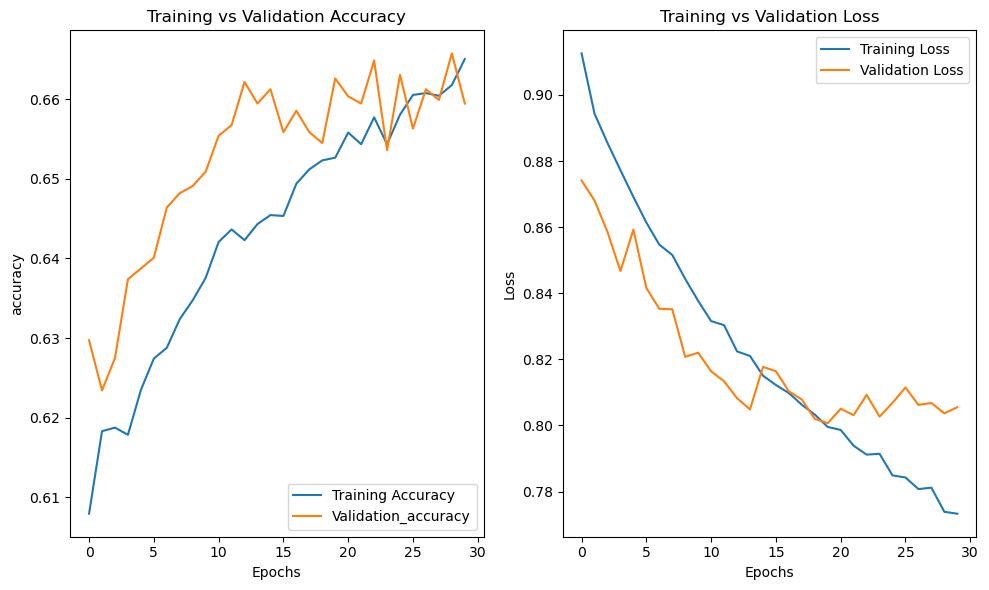

In [35]:
plt.figure(figsize = (10,6))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

* `Visualization:` We plot the training and validation accuracy/loss curves to evaluate model performance visually.
* `Evaluation:` We evaluate the model on the test data to get the loss and accuracy metrics.

In [36]:
# Evaluate model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6475 - loss: 0.8118
Test Loss: 0.815169095993042, Test Accuracy: 0.6418017745018005


In [37]:
# Predictions
y_pred = model_2.predict(x_test)
y_prediction = [np.argmax(x) for x in y_pred]
y_actual = [np.argmax(x) for x in y_test]

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [38]:
# Classification report
print(classification_report(y_actual, y_prediction))

              precision    recall  f1-score   support

           0       0.47      0.01      0.02      1699
           1       0.23      0.93      0.37       629
           2       0.10      0.05      0.07       447

    accuracy                           0.22      2775
   macro avg       0.27      0.33      0.15      2775
weighted avg       0.36      0.22      0.11      2775



### 11. Further Improvement with spaCy Pre-Trained Embeddings
- Use spaCy's `en_core_web_lg` model for embeddings.
- Create an embedding matrix for the vocabulary in the dataset.


In [49]:
import spacy

In [50]:
# Load spaCy model
nlp = spacy.load("en_core_web_lg")
embedding_dim = nlp.vocab.vectors_length

In [51]:
# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

In [52]:
for word, i in word_index.items():
    if word in nlp.vocab:
        embedding_matrix[i] = nlp.vocab[word].vector
    else:
        embedding_matrix[i] = np.random.uniform(-0.1, 0.1, embedding_dim)

#### 11.1. **Model Development**
Create a deep learning model with the following architecture:
- Build an Bidirectional LSTM-based model.
- Use the pre-trained embeddings from spaCy.
- Layers include:
  - Embedding Layer (non-trainable)
  - LSTM Layers with Spatial Dropout
  - Dense Layer for classification.

In [63]:
# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_sch = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6)

In [64]:
from tensorflow.keras import regularizers

model = keras.Sequential([
    # Embedding Layer - kept the same but added dropout
    keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,  weights=[embedding_matrix], trainable=False),
    # First LSTM Block
    keras.layers.Bidirectional(keras.layers.LSTM(units=128, activation="tanh",return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
    keras.layers.BatchNormalization(),
    keras.layers.SpatialDropout1D(0.3),
    # Second LSTM Block
    keras.layers.Bidirectional(keras.layers.LSTM(units=64, activation="tanh",return_sequences=False, kernel_regularizer=regularizers.l2(0.01))),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    # Dense Layers
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation="softmax")
])

# Compile with learning rate scheduling
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [65]:
history = model.fit( x_train, y_train, batch_size=32,  epochs=30,validation_split=0.2,  callbacks=[early_stopping])

Epoch 1/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.5037 - loss: 7.8793 - val_accuracy: 0.6239 - val_loss: 2.4214
Epoch 2/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.5949 - loss: 2.0150 - val_accuracy: 0.6365 - val_loss: 1.2903
Epoch 3/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.6310 - loss: 1.2014 - val_accuracy: 0.6495 - val_loss: 1.0334
Epoch 4/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.6234 - loss: 1.0296 - val_accuracy: 0.6302 - val_loss: 0.9641
Epoch 5/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.6272 - loss: 0.9548 - val_accuracy: 0.6482 - val_loss: 0.9225
Epoch 6/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.6335 - loss: 0.9232 - val_accuracy: 0.6392 - val_loss: 0.9413
Epoch 7/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.6349 - loss: 0.9189 - val_accuracy: 0.6509 - val_loss: 0.8793
Epoch 8/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.6461 - loss: 0.8709 - 

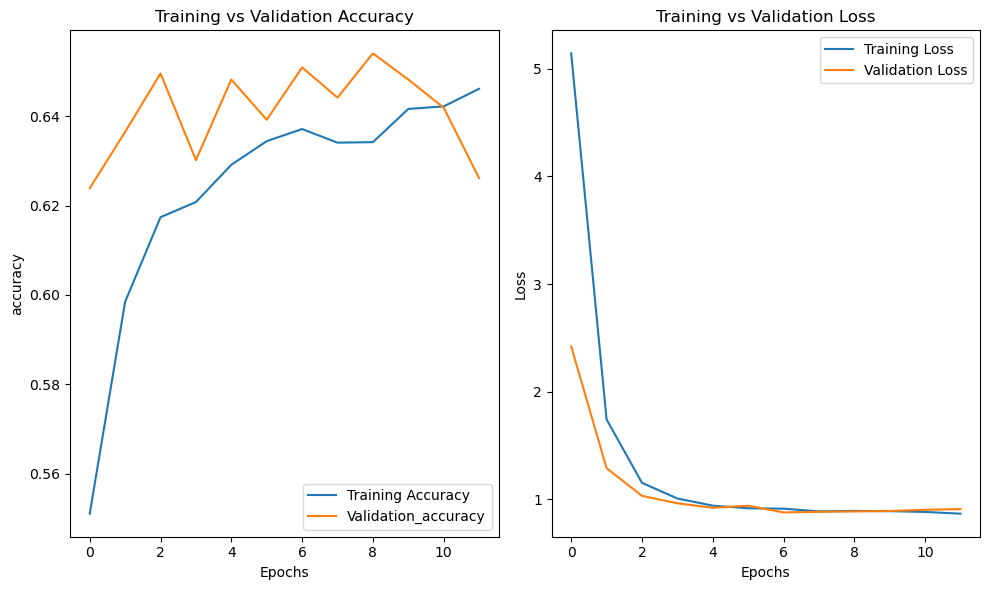

In [66]:
plt.figure(figsize = (10,6))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()